In [1]:
INDEX = ["nasdaq100", "sp500", "nifty500"][0]


In [2]:
type(INDEX)

str

In [3]:
import csv
import os, sys
import pickle
import math
from queue import PriorityQueue
from tkinter import N

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import pickle

mpl.rcParams['figure.dpi']= 300

from sklearn.metrics import accuracy_score, ndcg_score
#from torchinfo import summary
from tqdm import tqdm
from utils import (mean_absolute_percentage_error,
                   load_or_create_dataset_graph,
                   mean_square_error, root_mean_square_error)

# from models.model_sai import Trans

from torch.nn import Linear, ReLU, Dropout
from torch_geometric.nn import Sequential, GCNConv, JumpingKnowledge
from torch_geometric.nn import global_mean_pool

#import tensorflow_ranking as tfr

# from pytorchltr.loss import LambdaNDCGLoss1, LambdaNDCGLoss2
from torchmetrics.functional import retrieval_normalized_dcg

from random import randint
import wandb
GPU = 3
LR = 0.0006
BS = 128
W = 20
T = 20
LOG = False
D_MODEL = 20
N_HEAD  = 5
DROPOUT = 0.1
D_FF    = 1024
ENC_LAYERS = 1
DEC_LAYERS = 1
MAX_EPOCH = 10
USE_POS_ENCODING = False
USE_GRAPH = [True, False, 'hgat', 'rgat', 'gcn'][2]
HYPER_GRAPH = [True, False][1]
USE_RELATION_GRAPH = ['gcn', 'hypergraph', 'with_sector', False][3]
USE_KG = [True, False][1]
PREDICTION_PROBLEM = 'value'
RUN = randint(1, 100000)
PLOT = False
MODEL_TYPE = '' #'random'
ENCODER_LAYER = ['gru', 'transf', 'lstm'][2]

tau_choices = [5]
tau_positions = [5]

In [4]:

PREDICTION_PROBLEM = 'value'
save_path = "data/pickle/"+INDEX+"/full_graph_data_correct-P25-W"+str(20)+"-T"+str(20)+"_"+str(PREDICTION_PROBLEM)+".pkl"

dataset, company_to_id, graph, hyper_data = load_or_create_dataset_graph(INDEX="nasdaq100", W=20, T=20, save_path=save_path, problem=PREDICTION_PROBLEM, fast=False)


--- File exists: Loading Dataset ---


In [5]:
num_nodes = len(company_to_id.keys())
node_type = torch.load('./kg/tkg_create/node_tensor_usa.pt')
config = {
            'entity_total': 6500,
            'relation_total': 57,
            'L1_flag': False,
            'node_type': node_type,
            'num_node_type': 14
        }

In [6]:

def rank_loss(prediction, ground_truth):
    all_one = torch.ones(prediction.shape[0], 1, dtype=torch.float32).to(device)
    prediction = prediction.unsqueeze(dim=1)
    ground_truth = ground_truth.unsqueeze(dim=1)
    #print(prediction.shape, ground_truth.shape, base_price.shape)
    return_ratio = prediction 
    true_return_ratio = ground_truth - 1

    pre_pw_dif = torch.sub(
        return_ratio @ all_one.t(),                  # C x C
        all_one @ return_ratio.t()                   # C x C
    )
    gt_pw_dif = torch.sub(
        all_one @ true_return_ratio.t(),
        true_return_ratio @ all_one.t()
    )

    rank_loss = torch.mean(
        F.relu(-1*pre_pw_dif * gt_pw_dif )
    )
   
    return rank_loss 

def evaluate(prediction, ground_truth, bestret, worstret, K):
    return_ratio = prediction - 1
    true_return_ratio = ground_truth - 1
    bestret = bestret - 1
    worstret = worstret - 1

    #print("True top k: ", torch.topk(true_return_ratio.squeeze(), k=3, dim=0))
    #print("Predicted top k: ", torch.topk(return_ratio.squeeze(), k=3, dim=0))

    target_obtained_return_ratio = torch.topk(true_return_ratio, k=K, dim=0)[0].mean()

    #random = torch.randint(0, prediction.shape[0]-1, (K,))
    #random_return_ratio = true_return_ratio[random].mean()
    
    topk_predicted = torch.topk(return_ratio, k=K, dim=0)[1]

    #global MODEL_TYPE
    #if MODEL_TYPE == 'random':
    #    topk_predicted = random

    obtained_return_ratio = true_return_ratio[topk_predicted].mean()
    best_return_ratio = bestret[topk_predicted].mean()
    worst_return_ratio = worstret[topk_predicted].mean()
    #return_ratio = -1*return_ratio
    #obtained_return_ratio += true_return_ratio[torch.topk(return_ratio.squeeze(), k=K, dim=0)[1]].mean()
    #obtained_return_ratio /= 2

    a_cat_b, counts = torch.cat([torch.topk(return_ratio.squeeze(), k=K, dim=0)[1], torch.topk(true_return_ratio.squeeze(), k=K, dim=0)[1]]).unique(return_counts=True)
    accuracy = a_cat_b[torch.where(counts.gt(1))].shape[0] / K

    return obtained_return_ratio, target_obtained_return_ratio, accuracy, best_return_ratio, worst_return_ratio


top_k_choice = [1, 5]

def calculate_ndcg(predict, true, k):
    tt = torch.topk(true, k, dim=0)[1]
    rel_score = torch.arange(k, 0, -1).to(device)
    true_rel = torch.zeros_like(predict).long()
    true_rel[tt] = rel_score
    return retrieval_normalized_dcg(predict, true_rel)

def approxNDCGLoss(y_pred, y_true, eps=1e-10, padded_value_indicator=-1, alpha=1.):
    """
    Loss based on approximate NDCG introduced in "A General Approximation Framework for Direct Optimization of
    Information Retrieval Measures". Please note that this method does not implement any kind of truncation.
    :param y_pred: predictions from the model, shape [batch_size, slate_length]
    :param y_true: ground truth labels, shape [batch_size, slate_length]
    :param eps: epsilon value, used for numerical stability
    :param padded_value_indicator: an indicator of the y_true index containing a padded item, e.g. -1
    :param alpha: score difference weight used in the sigmoid function
    :return: loss value, a torch.Tensor
    """
    # shuffle for randomised tie resolution
    random_indices = torch.randperm(y_pred.shape[-1])
    y_pred_shuffled = y_pred.unsqueeze(dim=0)[:, random_indices]
    y_true_shuffled = y_true.unsqueeze(dim=0)[:, random_indices]

    y_true_sorted, indices = y_true_shuffled.sort(descending=True, dim=-1)

    mask = y_true_sorted == padded_value_indicator

    preds_sorted_by_true = torch.gather(y_pred_shuffled, dim=1, index=indices)
    preds_sorted_by_true[mask] = float("-inf")

    max_pred_values, _ = preds_sorted_by_true.max(dim=1, keepdim=True)

    preds_sorted_by_true_minus_max = preds_sorted_by_true - max_pred_values

    cumsums = torch.cumsum(preds_sorted_by_true_minus_max.exp().flip(dims=[1]), dim=1).flip(dims=[1])

    observation_loss = torch.log(cumsums + eps) - preds_sorted_by_true_minus_max

    observation_loss[mask] = 0.0

    return torch.mean(torch.sum(observation_loss, dim=1))

def approx_rank(logits):
    """_summary_

    Args:
        logits (_type_): A `Tensor` with shape [batch_size, list_size]. Each value is the
      ranking score of the corresponding item.

    Returns:
        _type_: A `Tensor` of ranks with the same shape as logits.
    """
    list_size = logits.shape[1]
    x = logits.unsqueeze(2).repeat(1, 1, list_size)
    y = logits.unsqueeze(1).repeat(1, list_size, 1)
    rank = torch.sigmoid(x - y)
    rank = torch.sum(rank, dim=-1) #+ 0.5
    return rank

def approx_ndcg_loss(logits, labels):
    """_summary_

    Args:
        logits (_type_): A `Tensor` with shape [batch_size, list_size]. Each value is the
      ranking score of the corresponding item.
        labels (_type_): A `Tensor` with shape [batch_size, list_size]. Each value is the
      relevance label of the corresponding item.

    Returns:
        _type_: A `Tensor` of ndcg loss with shape [batch_size].
    """
    rank = approx_rank(logits)
    #print("logits", torch.topk(logits, k=5, dim=-1), torch.topk(rank, k=5, dim=-1))
    return - retrieval_normalized_dcg(rank, labels)



In [7]:
kg_file_name = './kg/tkg_create/temporal_kg.pkl'
# if INDEX == 'nifty500':
#     kg_file_name = './kg/tkg_create/temporal_kg_nifty.pkl'
with open(kg_file_name, 'rb') as f:
    pkl_file =pd.read_pickle(f)

    # if "nasdaq" in INDEX:
    kg_map = pkl_file['nasdaq_map']
    # elif "sp" in INDEX:
    #     kg_map = pkl_file['sp_map']
    # elif "nifty" in INDEX:
    #     kg_map = pkl_file['nifty_map']
#print(kg_map)

# if USE_KG:
    #kg_file_name = './kg/profile_and_relationship/wikidata/'+INDEX+'_relations_kg.pkl'

    relation_kg = None
    
    """
    kg_file_name = './kg/profile_and_relationship/wikidata/entire_kg.pkl'
    with open(kg_file_name, 'rb') as f:
        pkl_file = pickle.load(f)
        relation_kg = pkl_file['kg']
        if INDEX == 'nasdaq100':
            kg_index = pkl_file['nasdaq_map']
        else:
            kg_index = pkl_file['sp_map']
    
    head, relation, tail = relation_kg[0].long(), relation_kg[1].long(), relation_kg[2].long()
    print(head.max(), relation.max(), tail.max())
    head, relation, tail, kg_index = head.to(device), relation.to(device), tail.to(device), kg_index.to(device)
    relation_kg = (head, relation, tail, kg_index)
    """
# else:
#     relation_kg = None

In [8]:
device = torch.device("cuda:"+str(5))
INDEX = ["nasdaq100", "sp500", "nifty500"][1]
key = INDEX
file_path = './kg/profile_and_relationship/wikidata/relation_graph.pkl'
with open(file_path, 'rb') as f:
    relation_graph = pickle.load(f)[key]
relation_graph = relation_graph.to(device)

In [9]:
graph_nodes_batch = torch.zeros(graph.x.shape[0]).to(device)
graph = graph.to(device)
graph_data = {
    'x': graph.x,
    'edge_list': graph.edge_index,
    'batch': graph_nodes_batch
}
file_path = './kg/profile_and_relationship/wikidata/relation_graph.pkl'
with open(file_path, 'rb') as f:
    relation_graph = pickle.load(f)[key]
relation_graph = relation_graph.to(device)

In [10]:
test_rr_list = [[], [], []]

In [11]:
from models.model_trans_dec import Trans
for tau in tau_choices:
    tau_pos = tau_positions.index(tau)

    print("Tau: ", tau, "Tau Position: ", tau_pos)

    start_time, train_begin = 0, 0
    test_mean_rr, test_mean_trr, test_mean_err, test_mean_rrr = [[], [], []], [[], [], []], [[], [], []], [[], [], []]
    test_mean_ndcg, test_mean_acc = [[], [], [], []], [[], [], []]
    test_mean_brr, test_mean_wrr, test_mean_sharpe = torch.zeros(4).to(device), torch.zeros(4).to(device), [[], [], []]
    def collate_fn(instn):
        tkg = instn[0][1]
        instn = instn[0][0]
        df = torch.Tensor(np.array([x[0] for x in instn])).unsqueeze(dim=2)
        for i in range(1, 5):
            df1 = torch.Tensor(np.array([x[i] for x in instn])).unsqueeze(dim=2)
            df = torch.cat((df, df1), dim=2)
        min_val = df.min()
        max_val = df.max()

        # Normalize tensor to the range [-1, 1]
        normalized_tensor = 2 * (df - min_val) / (max_val - min_val) - 1
        target = torch.Tensor(np.array([x[7][tau_pos] for x in instn]))
        movement = target >= 1
        best_case, worst_case = torch.Tensor(np.array([x[11][tau_pos+1] for x in instn])), torch.Tensor(np.array([x[10][tau_pos+1] for x in instn]))
        best_case = best_case / torch.Tensor(np.array([x[10][0] for x in instn]))
        worst_case = worst_case / torch.Tensor(np.array([x[11][0] for x in instn]))

        return (normalized_tensor, movement, tkg, best_case, worst_case)
    train_loader    = DataLoader(dataset[train_begin:start_time+400], 1, shuffle=True, collate_fn=collate_fn, num_workers=1)
    model  = Trans(W, T, D_MODEL, N_HEAD, ENC_LAYERS, DEC_LAYERS, D_FF, DROPOUT, USE_POS_ENCODING, USE_GRAPH, HYPER_GRAPH, USE_KG, num_nodes, config, "transf", USE_RELATION_GRAPH)
    model.to(device)
    break


/data/home/saihadnoor/anaconda3/lib/python3.11/site-packages/torchkge/utils/data_redundancy.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/data/home/saihadnoor/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Tau:  5 Tau Position:  0


In [12]:
movement_values = []

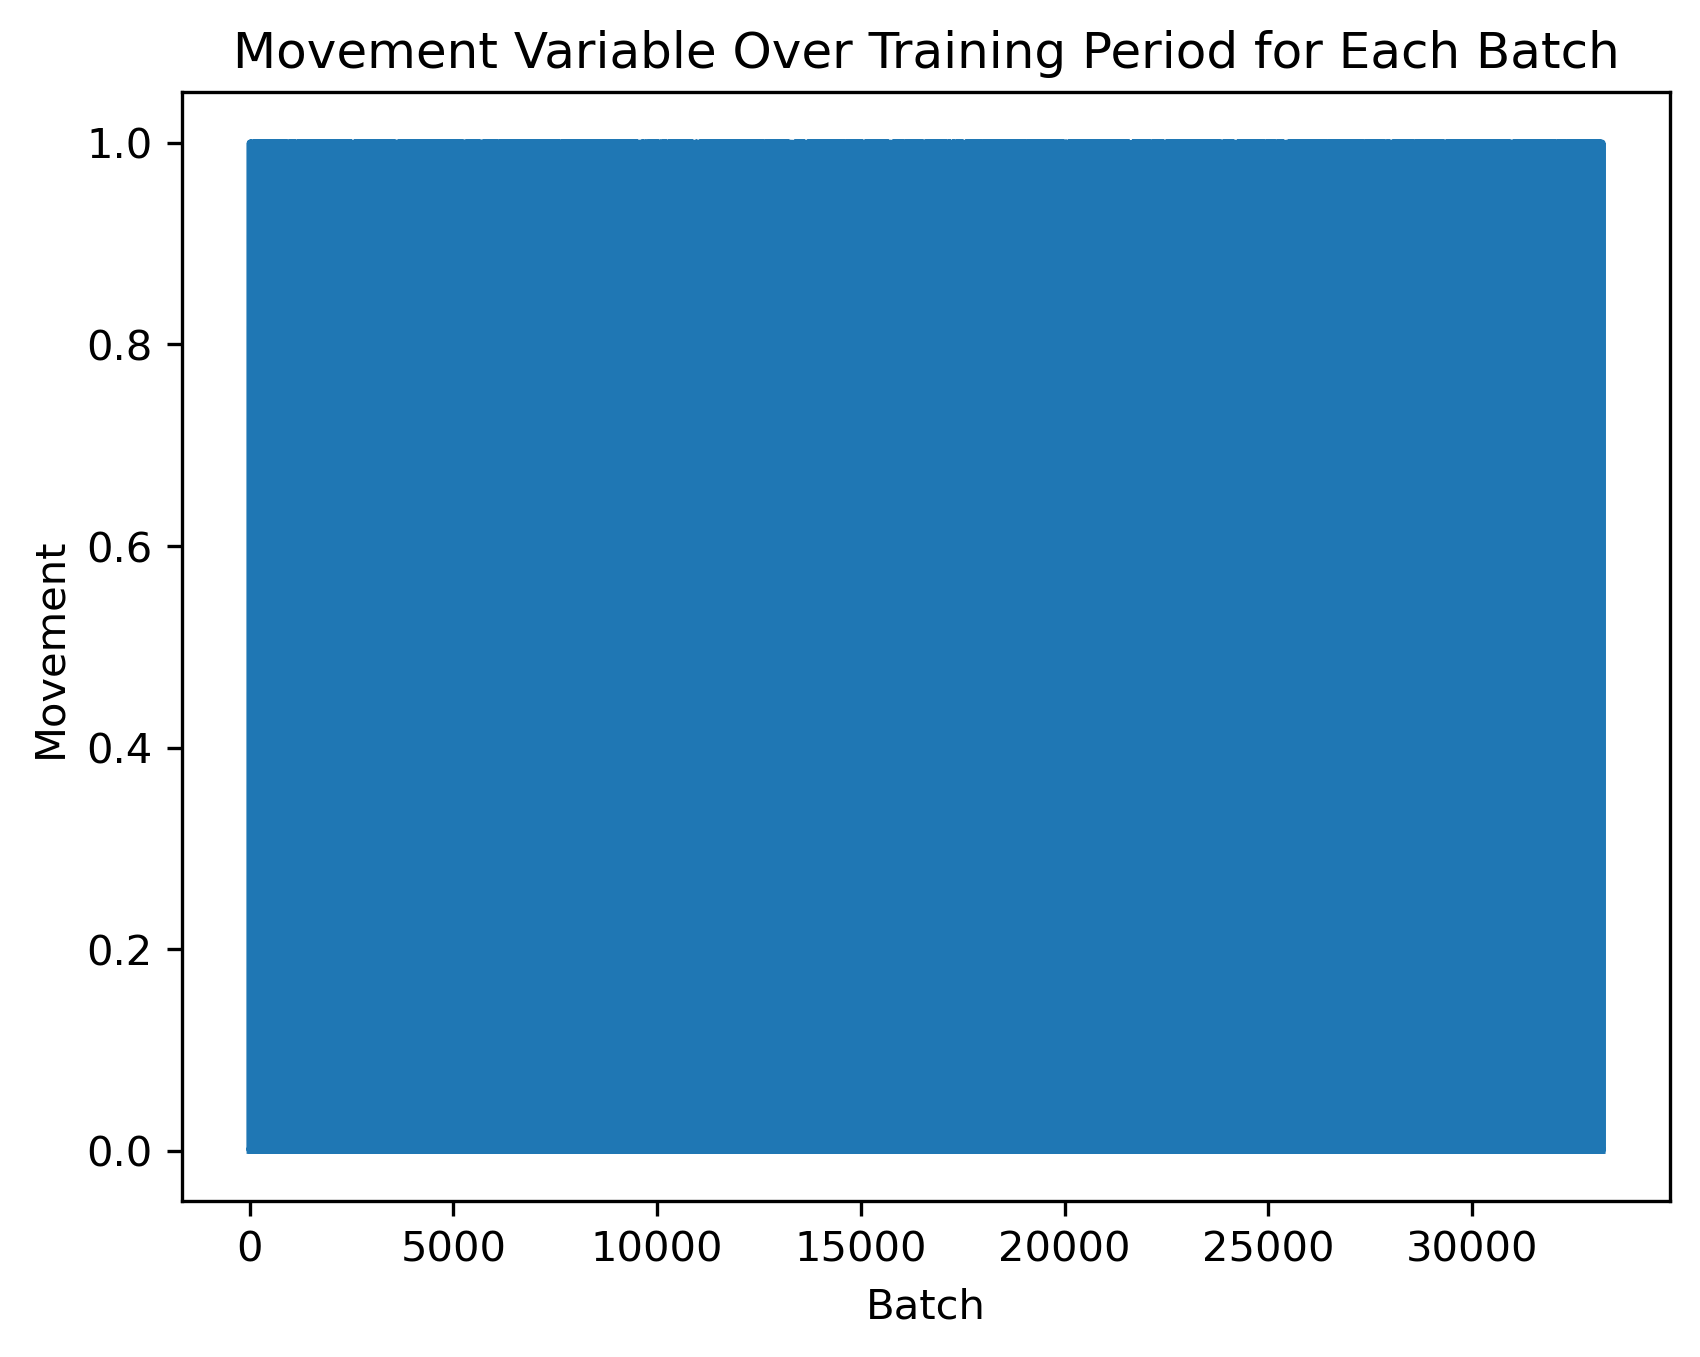

Length of Y-axis: 33200
Length of X-axis: 400


In [13]:
import matplotlib.pyplot as plt

# Assuming train_loader is defined and contains your data
movement_values = []
num_batches = len(train_loader)

for batch in train_loader:
    _, movement, _, _, _ = batch  # Extracting the movement from the batch
    movement_values.extend(movement.tolist())  # Appending the movement values to the list

# Plotting the movement variable for each batch
plt.plot(movement_values)
plt.title('Movement Variable Over Training Period for Each Batch')
plt.xlabel('Batch')
plt.ylabel('Movement')
plt.show()

# Getting the length of y-axis and x-axis
length_of_y_axis = len(movement_values)
length_of_x_axis = num_batches
print("Length of Y-axis:", length_of_y_axis)
print("Length of X-axis:", length_of_x_axis)


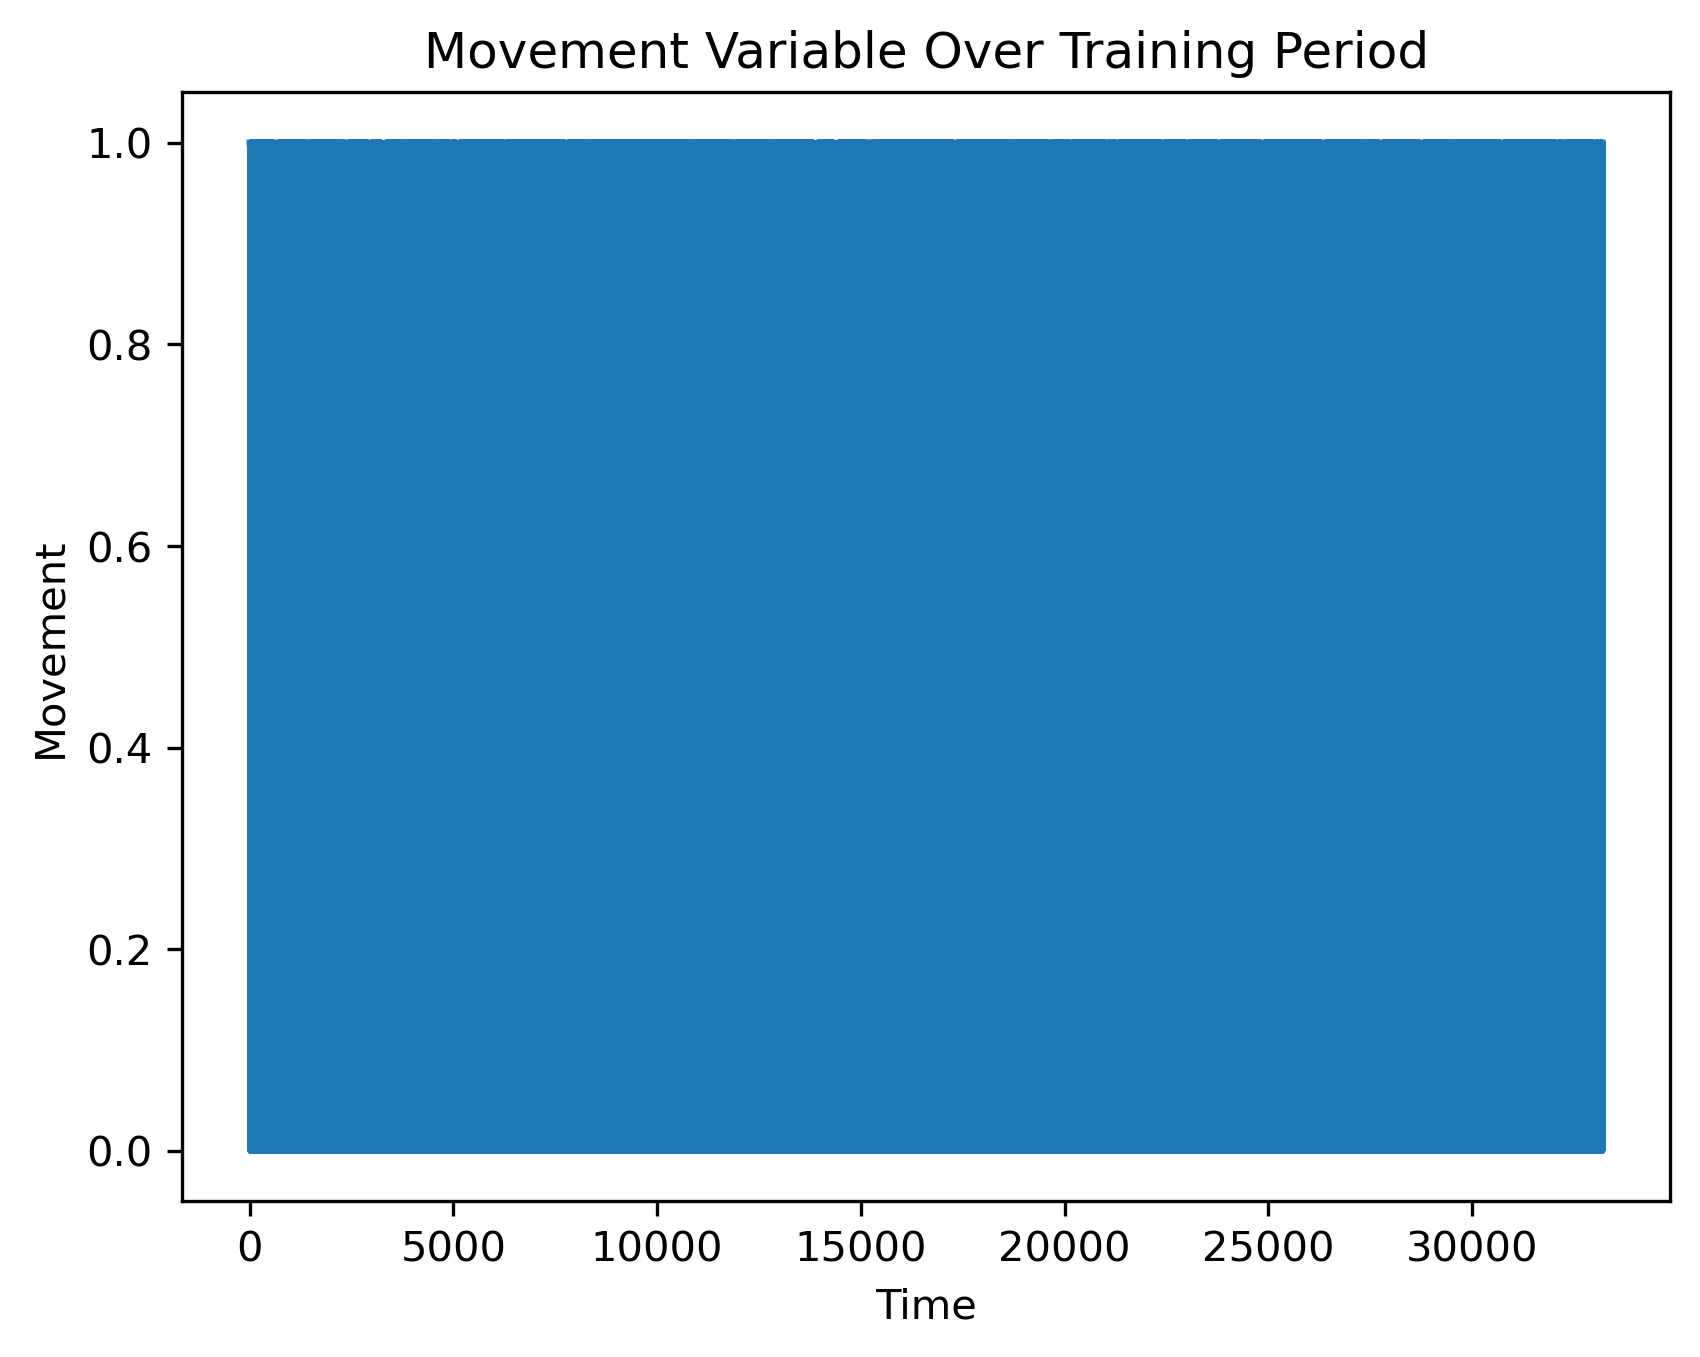

In [14]:
import matplotlib.pyplot as plt

# Assuming train_loader is defined and contains your data
movement_values = []

for batch in train_loader:
    _, movement, _, _, _ = batch  # Extracting the movement from the batch
    movement_values.extend(movement.tolist())  # Appending the movement values to the list

# Plotting the movement variable
plt.plot(movement_values)
plt.title('Movement Variable Over Training Period')
plt.xlabel('Time')
plt.ylabel('Movement')
plt.show()


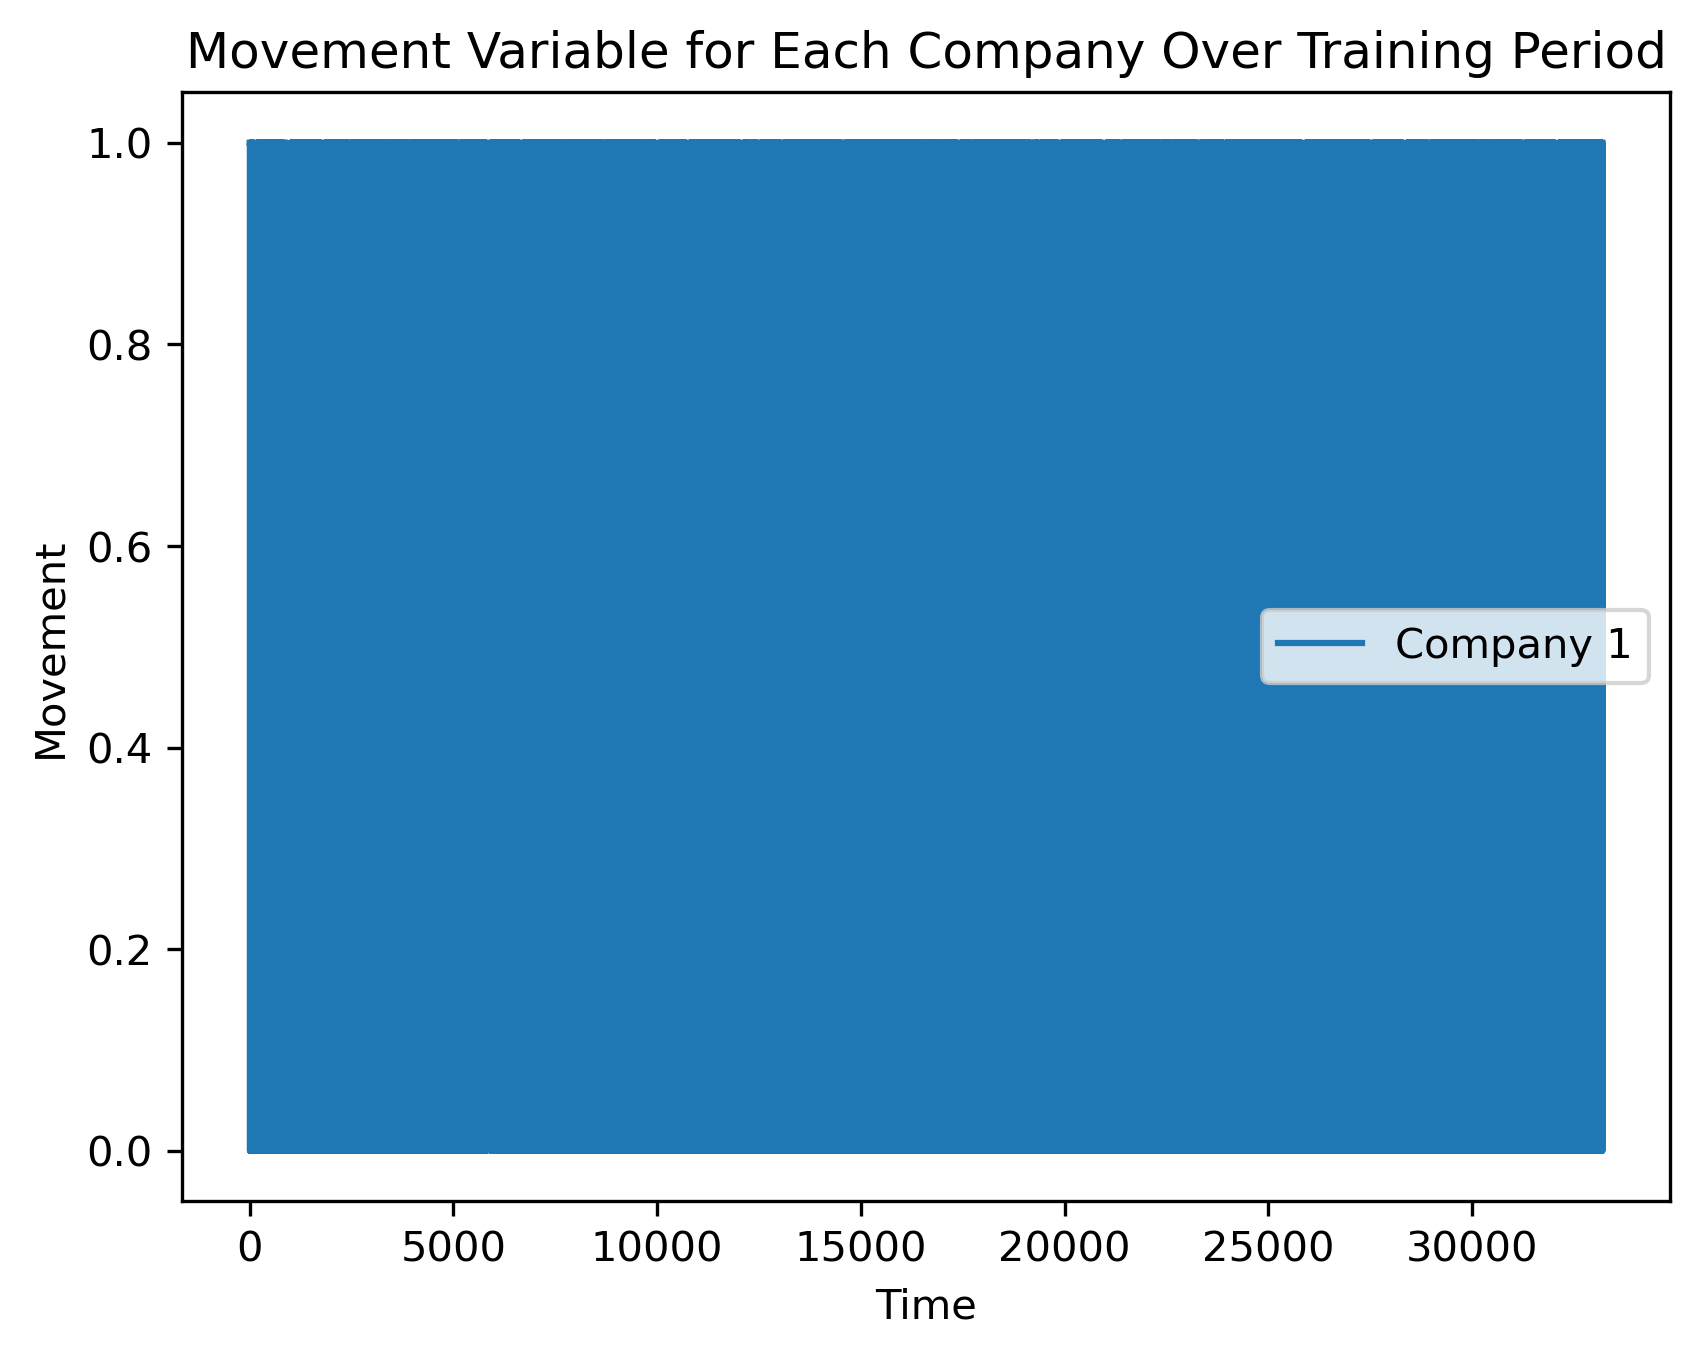

TypeError: xlabel() missing 1 required positional argument: 'xlabel'

In [15]:
import matplotlib.pyplot as plt

# Assuming train_loader is defined and contains your data
movement_values_per_company = [[] for _ in range(83)]  # Assuming num_companies is defined

for batch in train_loader:
    _, movement, _, _, _ = batch  # Extracting the movement from the batch
    num_stocks = movement.size(1)
    for i in range(num_stocks):
        movement_values_per_company[i].extend(movement[:, i].tolist())  # Appending the movement values for each company to the respective list

# Plotting the movement variable for each company
for i, company_movement in enumerate(movement_values_per_company):
    plt.plot(company_movement, label=f'Company {i+1}')
    break

plt.title('Movement Variable for Each Company Over Training Period')
plt.xlabel('Time')
plt.ylabel('Movement')
plt.legend()
plt.show()
x_label_length = len(plt.xlabel().get_text())
y_label_length = len(plt.ylabel().get_text())
print


In [19]:
for xb, yb, tkg, bestret, worstret in train_loader:
    head, relation, tail, ts = tkg
    head, relation, tail, ts, kg_map = head.to(device), relation.to(device), tail.to(device), ts.to(device), kg_map.to(device)

    tkg = (head, relation, tail, ts, kg_map)

    xb      = xb.to(device)     
    yb      = yb.to(device) 
    bestret = bestret.to(device)
    worstret = worstret.to(device)
    class_counts = torch.bincount(yb.view(-1).long())
    num_classes = len(class_counts)
    print(num_classes)
    total_samples = len(yb)
    class_weights = total_samples / (num_classes * class_counts.float())
    print(xb.shape)
    x_t = xb.transpose(1,2)
    print(x_t.shape)
    print(yb.shape)
    y_hat, kg_loss = model(xb, yb, graph_data, relation_kg, tkg, relation_graph)
    print(kg_loss)
    class_counts = torch.bincount(yb.view(-1).long())
    print(class_counts)
    break
    

2
torch.Size([83, 20, 5])
torch.Size([83, 5, 20])
torch.Size([83, 1])


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:5 and cuda:4! (when checking argument for argument attn_bias in method wrapper_CUDA___scaled_dot_product_efficient_attention)

In [ ]:

kg_file_name = './kg/tkg_create/temporal_kg.pkl'
with open(kg_file_name, 'rb') as f:
    pkl_file = pickle.load(f)
    relation_kg = pkl_file['temporal_kg']

In [ ]:

for tau in tau_choices:
    tau_pos = tau_positions.index(tau)

    print("Tau: ", tau, "Tau Position: ", tau_pos)

    # ----------- Batching the data -----------
    def collate_fn(instn):
        tkg = instn[0][1]
        instn = instn[0][0]

        # df: shape: Companies x W+1 x 5 (5 is the number of features)
        df = torch.Tensor(np.array([x[0] for x in instn])).unsqueeze(dim=2)
        #df = torch.Tensor(np.array([x[1] for x in instn])).unsqueeze(dim=2) - torch.Tensor(np.array([x[2] for x in instn])).unsqueeze(dim=2)
        for i in range(1, 5):
            df1 = torch.Tensor(np.array([x[i] for x in instn])).unsqueeze(dim=2)
            df = torch.cat((df, df1), dim=2)

        # Shape: Companies x 1
        target = torch.Tensor(np.array([x[7][tau_pos] for x in instn]))

        # Shape: Companies x 1
        #movement = target >= 1

        best_case, worst_case = torch.Tensor(np.array([x[11][tau_pos+1] for x in instn])), torch.Tensor(np.array([x[10][tau_pos+1] for x in instn]))
        best_case = best_case / torch.Tensor(np.array([x[10][0] for x in instn]))
        worst_case = worst_case / torch.Tensor(np.array([x[11][0] for x in instn]))

        return (df, target, tkg, best_case, worst_case)


    start_time, train_begin = 0, 0
    test_mean_rr, test_mean_trr, test_mean_err, test_mean_rrr = [[], [], []], [[], [], []], [[], [], []], [[], [], []]
    test_mean_ndcg, test_mean_acc = [[], [], [], []], [[], [], []]
    test_mean_brr, test_mean_wrr, test_mean_sharpe = torch.zeros(4).to(device), torch.zeros(4).to(device), [[], [], []]

    for phase in range(1, 22):
        print("Phase: ", phase)


        # with open("/data5/home/saihadnoor/Stock_Origin_Kawin/Phase-Stock-KG/pickle/"+INDEX+"_"+str(phase)+"_25phase.pkl", "rb") as f:
        #     # pickle.dump(dataset[train_begin:start_time+400], f)
        #     dataset1 = pickle.load(f)
        #     print(len(dataset1))
        # train_loader    = DataLoader(dataset1, 1, shuffle=True, collate_fn=collate_fn, num_workers=1)
        train_loader    = DataLoader(dataset[train_begin:start_time+400], 1, shuffle=True, collate_fn=collate_fn, num_workers=1)
        # val_loader      = DataLoader(dataset[start_time+400:start_time+450], 1, shuffle=False, collate_fn=collate_fn)
        # test_loader     = DataLoader(dataset[start_time+450:start_time+550], 1, shuffle=False, collate_fn=collate_fn)   
        #print(len(dataset), len(dataset[start_time:start_time+1000]), len(dataset[start_time+1000:start_time+1100]), len(dataset[start_time+1100:start_time+1400]))
        start_time += 100
        if start_time >= 300:
            train_begin += 100      

        node_type = torch.load('./kg/tkg_create/node_tensor_usa.pt')
        config = {
            'entity_total': 6500,
            'relation_total': 57,
            'L1_flag': False,
            'node_type': node_type,
            'num_node_type': 14
        }

        if INDEX == 'nifty500':
            node_type = torch.load('./kg/tkg_create/node_tensor_india.pt')
            config = {
                'entity_total': 1200,
                'relation_total': 57,
                'L1_flag': False,
                'node_type': node_type,
                'num_node_type': 16
            }
        model  = Trans(W, T, D_MODEL, N_HEAD, ENC_LAYERS, DEC_LAYERS, D_FF, DROPOUT, USE_POS_ENCODING, USE_GRAPH, HYPER_GRAPH, USE_KG, num_nodes, config, "transf", USE_RELATION_GRAPH)
        if phase == 1:
            print(model)
        model.to(device)

        #if phase > 1:
        #    model.load_state_dict(torch.load("models/saved_models/best_model_"+INDEX+str(W)+"_"+str(T)+"_"+str(RUN)+".pt"))
        #nasdaq 1e-5, 4e-5
        opt_c = torch.optim.AdamW(model.parameters(), lr = 2e-5, betas=(0.9, 0.999), eps=1e-08)
        opt_kg = torch.optim.Adam(model.parameters(), lr = 4e-5, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
        #opt_c = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0, nesterov=True)

        prev_val_loss, best_val_loss = float("infinity"), float("infinity")
        val_loss_history = []
        for ep in range(4):
            print("Epoch: " + str(ep+1))
            model.train()
            rr, true_rr, accuracy, best_rr, worst_rr = torch.zeros(4).to(device), torch.zeros(4).to(device), torch.zeros(4).to(device), torch.zeros(4).to(device), torch.zeros(4).to(device)
            ndcg, sharpe_ratio = torch.zeros(4).to(device), torch.zeros(4).to(device)
            sharpe = [[], [], []]
            yb_store, yhat_store, yb_store2 = [], [], []
            for xb, yb, tkg, bestret, worstret in train_loader:
                head, relation, tail, ts = tkg
                head, relation, tail, ts, kg_map = head.to(device), relation.to(device), tail.to(device), ts.to(device), kg_map.to(device)

                tkg = (head, relation, tail, ts, kg_map)

                xb      = xb.to(device)     
                yb      = yb.to(device) 
                bestret = bestret.to(device)
                worstret = worstret.to(device)

                y_hat, kg_loss = model(xb, yb, graph_data, relation_kg, tkg, relation_graph)
                y_hat = y_hat.squeeze()



Tau:  5 Tau Position:  0
Phase:  1
Trans(
  (embeddings): Embedding(105, 10)
  (transformer_decoder_first): TransformerDecoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=20, out_features=20, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=20, out_features=20, bias=True)
        )
        (linear1): Linear(in_features=20, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1024, out_features=20, bias=True)
        (norm1): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
        (norm3): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False

KeyboardInterrupt: 

In [ ]:

kg_file_name = './kg/tkg_create/temporal_kg.pkl'
with open(kg_file_name, 'rb') as f:
    pkl_file = pickle.load(f)
    relation_kg = pkl_file['temporal_kg']

In [ ]:
print(len(relation_kg))

370567


In [ ]:
relation_kg.head()

,head,tail,relation,timestamp,expiry_ts
0,1007,2591,1,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00
5052,1340,4079,12,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00
5051,1232,4078,12,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00
5050,1232,4077,12,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00
5049,1232,4076,12,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00


In [ ]:
relation_kg.head()['timestamp'].dt.year.values

array([1970, 1970, 1970, 1970, 1970])

In [ ]:
tkg = relation_kg

In [ ]:
a =tkg[0].unsqueeze(0)
b= tkg[2].unsqueeze(0)
print(a.shape,b.shape)

torch.Size([1, 7569]) torch.Size([1, 7569])


In [ ]:
edge = torch.cat((a,b),dim=0)
print(edge)
edge.shape

tensor([[1007, 1340, 1232,  ..., 1130, 1135,  845],
        [2591, 4079, 4078,  ..., 1112, 1112,  600]], device='cuda:5')


torch.Size([2, 7569])

In [ ]:
c = tkg[3][:, 1]
print(c)
c.shape

tensor([0, 0, 0,  ..., 0, 0, 7], device='cuda:5')


torch.Size([7569])

In [ ]:
len(tkg[4])

83